In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA

import skimage.io as io
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

import os
from tqdm import tqdm
from glob import glob

In [15]:
#导入图像并转化为numpy数组
train_path = 'image/'
tumor_label=pd.read_csv('label.csv')
img_size = 200
label = []
nub_train = len(glob(train_path + '/*.jpg'))
image_data = np.zeros((nub_train,img_size,img_size,3),dtype=np.uint8)

i = 0   
for img_path in tqdm(glob(train_path + '/*.jpg')):
    img = Image.open(img_path)
    img = img.resize((img_size,img_size)) #图片resize
    arr = np.asarray(img) #图片转array
    image_data[i, :, :, :] = arr #赋值
    i += 1

for i in range(3000):
    data = tumor_label['label'][i]
    if data == 'no_tumor':
        label.append(data)
    else :
        label.append('yes_tumor')    
    
    
image_data = np.array(image_data,dtype='float32')/255.0
label = np.array(label)


100%|██████████| 3000/3000 [00:09<00:00, 301.23it/s]


In [16]:
new_image = np.delete(image_data, [1,2], axis=3 )

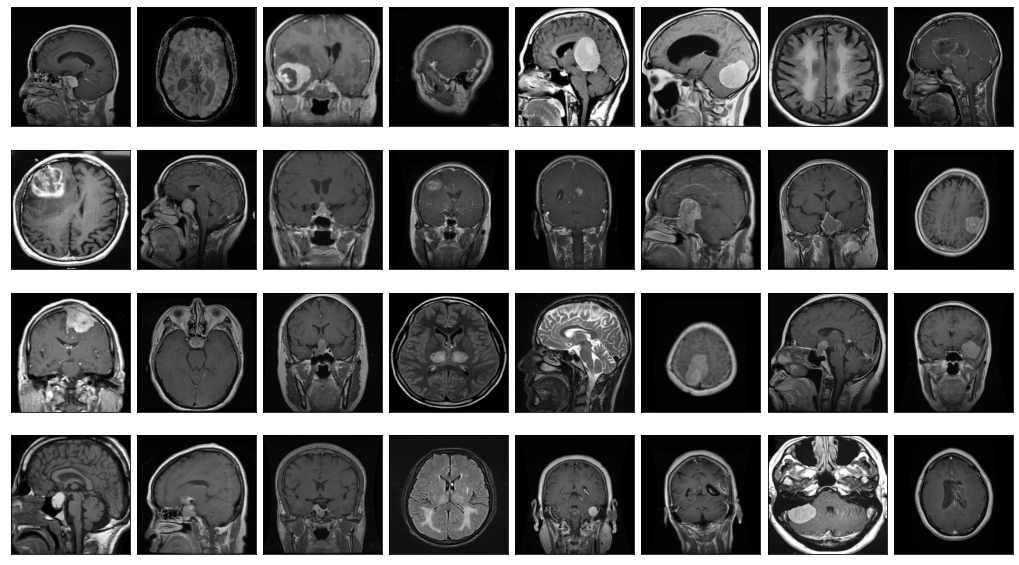

In [17]:
%matplotlib inline
plt.figure(figsize=(20,20))
for i in range(1,33):
    plt.subplot(4,8,i)
    plt.imshow(image_data[i-1])
    plt.xticks([])
    plt.yticks([])  
plt.subplots_adjust(left=0.1, bottom=0.5, right=0.8, wspace=0.01)
plt.show()

<IPython.core.display.Javascript object>


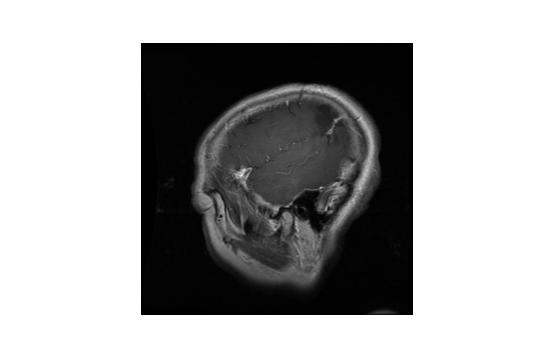

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.imshow(image_data[3])
plt.axis('off')
plt.show()

In [19]:
new_image = new_image.reshape(new_image.shape[0],-1)

In [20]:
df = pd.DataFrame(new_image)
df

,0,1,2,3,4,5,6,7,8,9,...,262134,262135,262136,262137,262138,262139,262140,262141,262142,262143
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.137255,0.141176,0.145098,0.149020,0.156863,0.160784,0.164706,0.164706,0.164706,0.160784,...,0.003922,0.003922,0.007843,0.000000,0.003922,0.000000,0.000000,0.117647,0.290196,0.372549
2,0.082353,0.047059,0.007843,0.000000,0.000000,0.011765,0.007843,0.000000,0.007843,0.007843,...,0.003922,0.003922,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.113725,0.125490,0.137255,0.141176,0.133333,0.149020,0.219608,0.345098,0.470588,0.537255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.239216,0.247059,0.262745,0.270588,0.270588,0.274510,0.282353,0.290196,0.278431,0.278431,...,0.011765,0.011765,0.015686,0.031373,0.023529,0.000000,0.007843,0.094118,0.207843,0.282353
2996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [21]:
#保留百分之95 PCA降维
def PCAPredict(X, k):
    
    pca = PCA(n_components=k)
    X_new = pca.fit_transform(X)  
    #Variance = pca.explained_variance_ratio_
    ncomp = pca.n_components_
    return X_new, ncomp

k1 = 0.95
X_new, ncomp = PCAPredict(new_image,k1)
#print(Variance)
print(ncomp)

839


In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_new, label, test_size=0.3, random_state=3)

In [23]:
'''param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(x_train, y_train)
'''

"param_grid = [\n  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},\n  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},\n ]\nsvc = svm.SVC()\nclf = GridSearchCV(svc, param_grid)\nclf.fit(x_train, y_train)\n"

In [24]:
def SVM(x_train,y_train, x_test):
    model = SVC(kernel='linear',C = 1.0)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return y_pred

y_pred=SVM(x_train,y_train, x_test)

print(accuracy_score(y_test,y_pred))

0.9266666666666666


In [25]:
def SVM(x_train,y_train, x_test):
    model = SVC(kernel='rbf', gamma=0.7, C=1.0)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return y_pred

y_pred=SVM(x_train,y_train, x_test)

print(accuracy_score(y_test,y_pred))

0.9122222222222223


In [ ]:
#需要进一步加上 交叉验证 或 GridsearchCV 等方法优化SVM超参数